In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import joblib, gc
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge, RidgeCV, ElasticNet, HuberRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, \
    RandomizedSearchCV, KFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from pygam import LinearGAM, s
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import lilliefors, het_white, acorr_breusch_godfrey
from scipy.stats import probplot, uniform, randint, shapiro
from scipy import stats


pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
SEED = 23

In [73]:
class IQROutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.lower_bound_ = None
        self.upper_bound_ = None
        self.outlier_share_ = None  # Store the share of outliers removed

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        IQR = Q3 - Q1
        
        self.lower_bound_ = Q1 - self.factor * IQR
        self.upper_bound_ = Q3 + self.factor * IQR
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        initial_row_count = len(X)
        
        is_within_bounds = (X >= self.lower_bound_) & (X <= self.upper_bound_)
        X_filtered = X[is_within_bounds.all(axis=1)]
        
        final_row_count = len(X_filtered)
        self.outlier_share_ = (initial_row_count - final_row_count) / initial_row_count
        
        if y is not None:
            y = pd.Series(y) if isinstance(y, np.ndarray) else y
            y_filtered = y.loc[X_filtered.index]
            return X_filtered, y_filtered
        
        return X_filtered
    
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X, y)

    def get_outlier_indices(self, X):
        X = pd.DataFrame(X)
        is_within_bounds = (X >= self.lower_bound_) & (X <= self.upper_bound_)
        outliers_mask = ~is_within_bounds.all(axis=1)
        return X[outliers_mask].index

    def get_bounds(self):
        bounds = pd.DataFrame({
            'Feature': self.lower_bound_.index,
            'Lower Bound': self.lower_bound_.values,
            'Upper Bound': self.upper_bound_.values
        })
        bounds.set_index('Feature', inplace=True)
        return bounds

    def print_outlier_share(self):
        if self.outlier_share_ is not None:
            print(f"Total share of outliers removed: {self.outlier_share_ * 100:.2f}%")
        else:
            print("Outlier share not calculated. Ensure `transform` method has been called.")


In [74]:
class StatmodelsWrapper(BaseEstimator):
    def __init__(self, model_type='ols', use_wls=False):
        self.model_type = model_type
        self.use_wls = use_wls
        self.model = None

    def fit(self, X, y):
        X = sm.add_constant(X)

        if self.model_type == 'ols':
            if self.use_wls:
                # Fit an OLS model to estimate residuals for WLS
                ols_model = sm.OLS(y, X).fit()
                residuals = ols_model.resid

                # Compute weights as the inverse of the squared residuals
                weights = 1 / (residuals ** 2 + np.finfo(float).eps)  # Adding epsilon to avoid division by zero

                # Fit the WLS model with the computed weights
                self.model = sm.WLS(y, X, weights=weights).fit()
            else:
                # Fit the OLS model
                self.model = sm.OLS(y, X).fit()

        elif self.model_type == 'logit':
            # Fit the logistic regression model
            self.model = sm.Logit(y, X).fit()
        
        self.summary = self.model.summary  # Store the summary as an attribute
        return self

    def predict(self, X):
        X = sm.add_constant(X)
        if self.model_type in ['ols', 'wls']:
            return self.model.predict(X)
        elif self.model_type == 'logit':
            # For logistic regression, return class labels (0 or 1) based on probability threshold of 0.5
            probabilities = self.model.predict(X)
            return (probabilities >= 0.5).astype(int)

    def predict_proba(self, X):
        if self.model_type == 'logit':
            X = sm.add_constant(X)
            probabilities = self.model.predict(X)
            # Return probabilities for class 0 and class 1
            return np.vstack((1 - probabilities, probabilities)).T
        else:
            raise NotImplementedError("Probability predictions are only available for logistic regression.")

In [77]:
def analyze_columns(df, include_columns):
    """
    Analyze specified columns of a DataFrame for skewness, kurtosis, and visual distribution.

    Parameters:
    - df: DataFrame to analyze.
    - include_columns: List of column names to include in the analysis.

    This function will print the skewness and kurtosis for each specified column, and display
    a distribution plot, a box plot, and a Q-Q plot for each.
    """
    for col in include_columns:
        if col in df.columns:
            print(f"Skewness of {col}:", df[col].skew())
            print(f"Kurtosis of {col}:", df[col].kurtosis())

            # Set up the matplotlib figure
            plt.figure(figsize=(14, 4))

            # Distribution plot
            plt.subplot(131)
            sns.histplot(df[col], kde=True)

            # Box plot
            plt.subplot(132)
            sns.boxplot(y=df[col])

            # Q-Q plot
            plt.subplot(133)
            probplot(df[col], plot=plt, rvalue=True, dist='norm')
            plt.suptitle(col)
            plt.show()
        else:
            print(f"Column '{col}' not found in DataFrame.")

In [78]:
def normality_tests(data):
    """
    Perform various statistical tests to assess the normality of a given dataset.

    This function conducts the following normality tests on the provided data:
    1. Shapiro-Wilk Test
    2. Kolmogorov-Smirnov Test
    3. Anderson-Darling Test
    4. Lilliefors Test
    5. D’Agostino’s K-squared Test

    Each test provides different insights into the normality of the distribution 
    of the dataset. The function prints the test statistic and p-value for each test.

    Parameters:
    data (array-like): A sequence of numerical data points. The data should be a 1D array-like 
                       structure (e.g., Python list, NumPy array, or Pandas Series).

    Returns:
    None: This function only prints the results of the normality tests to the console.
    """
    
    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = stats.shapiro(data)
    print(f'Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}')

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p = stats.kstest((data - np.mean(data)) / np.std(data), 'norm')
    print(f'Kolmogorov-Smirnov Test: Statistic={ks_stat}, p-value={ks_p}')

    # Anderson-Darling Test
    anderson_result = stats.anderson(data, dist='norm')
    print(f'Anderson-Darling Test: Statistic={anderson_result.statistic}')
    for i in range(len(anderson_result.critical_values)):
        sl, cv = anderson_result.significance_level[i], anderson_result.critical_values[i]
        print(f'At a significance level of {sl}, the critical value is {cv}.')

    # Lilliefors Test
    lilliefors_stat, lilliefors_p = lilliefors(data)
    print(f'Lilliefors Test: Statistic={lilliefors_stat}, p-value={lilliefors_p}')

    # D’Agostino’s K-squared Test
    dagostino_stat, dagostino_p = stats.normaltest(data)
    print(f"D'Agostino's K-squared Test: Statistic={dagostino_stat}, p-value={dagostino_p}")

In [79]:
def heatmap_spearman_significance(df):
    """
    Generate a heatmap displaying the Spearman's rank correlation coefficients 
    for each pair of variables in the provided DataFrame, with p-values and 
    significance levels annotated within each cell. Also, return a DataFrame with 
    the Spearman's rank correlation coefficients and p-values for each pair of variables.

    Parameters:
    df (DataFrame): A pandas DataFrame containing the variables for which correlations 
                    are to be calculated. The DataFrame should contain only numeric 
                    columns.

    Returns:
    DataFrame: A DataFrame containing the Spearman's rank correlation coefficients and 
               p-values for each pair of variables.
    """
    # Initialize matrices
    correlations = df.corr(method='spearman')
    annotations = pd.DataFrame(index=df.columns, columns=df.columns)
    results = []

    # Calculate Spearman correlation and p-values, format annotations
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                corr, p_val = stats.spearmanr(df[col1].dropna(), df[col2].dropna())
                # Determine the significance level
                if p_val < 0.01:
                    sig = '***'
                elif p_val < 0.05:
                    sig = '**'
                elif p_val < 0.1:
                    sig = '*'
                else:
                    sig = ''
                # Format annotation with correlation and p-value
                annotations.at[col1, col2] = f'{corr:.2f}\n({p_val:.3f}){sig}'
                # Append results to list
                results.append({'Pair': f'{col1}-{col2}', 'Correlation': corr, 'P-value': p_val})
            else:
                annotations.at[col1, col2] = ''

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlations, dtype=bool))

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlations, annot=annotations, mask=mask, cmap='coolwarm', fmt='', cbar_kws={'label': 'Spearman Correlation Coefficient'})
    plt.title("Spearman's Rank Correlation Heatmap with P-value and Significance Annotations")
    plt.show()

    # Convert results list to DataFrame and return
    results_df = pd.DataFrame(results)
    return results_df.set_index('Pair')

In [80]:
def high_corr(df_source, method='spearman', thsld=0.8, perc=0.95):
    """
    Remove columns from a DataFrame that are highly correlated with other columns.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame for which to identify and remove highly correlated columns.

    method : str, optional
        The correlation method to be used. 'pearson', 'kendall', 'spearman' are supported. 
        Default is 'spearman'.

    thsld : float, optional
        The absolute correlation threshold. Pairs of columns with correlation higher than this value 
        will be considered for removal. Default is 0.8.

    perc : float, optional
        The percentile to use for deciding which variable to remove from a highly correlated pair.
        Should be between 0 and 1. Default is 0.95.

    Returns:
    --------
    df : pandas.DataFrame
        A new DataFrame with highly correlated columns removed.
    to_delete: list
        A list of removed variables. 

    Notes:
    ------
    - For each pair of highly correlated columns, the function removes the one with the higher
      percentile value of correlation, based on the 'perc' parameter.
    - Prints out the columns that are removed and their percentile values.
    """
    df =  df_source.copy()
    corr = df.corr(method)
    high_corr_vars = []
    to_delete = [] 
    
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > thsld:
                colname_i = corr.columns[i]
                colname_j = corr.columns[j]

                # Calculate correlation for each variable
                perc_i = np.percentile(corr[colname_i], perc)
                perc_j = np.percentile(corr[colname_j], perc)

                # Decide which variable to remove from each correlated pair based on its highest percentile value in the correlation matrix.
                max_abs_value = max(abs(perc_i), abs(perc_j))
                if max_abs_value >= thsld:
                    if abs(perc_i) > abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))
                else:
                    if abs(perc_i) <= abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))

                    

    # Remove the variable with the highest mean correlation from each pair
    for var, perc_val in high_corr_vars:
        if var in df.columns:
            print(f"Removing {var} with {perc}th percentile = {perc_val}")
            del df[var]
            to_delete.append(var)
    print("Remaining columns:", df.columns)
    return df, to_delete

In [81]:
def compare_distributions(df_1, df_2, features=None):
    """
    Plots the distributions of specified features or target variable in two datasets.

    Parameters:
    - df_1: The first dataset (pandas DataFrame or Series).
    - df_2: The second dataset (pandas DataFrame or Series).
    - features: A list of feature names to compare. If None and df_1 is a DataFrame, all features are compared.
                This parameter is ignored if df_1 is a Series.
    """
    if isinstance(df_1, pd.DataFrame) and features is None:
        features = df_1.columns

    if isinstance(df_1, pd.Series) or isinstance(df_1, pd.DataFrame) and (features is None or len(features) == 1):
        # Handle the case where df_1 and df_2 are Series or single-column DataFrames
        plt.figure(figsize=(14, 6))

        # Plot the distribution for the first dataset
        sns.histplot(df_1, color='blue', label='Dataset 1', kde=True, stat="density", linewidth=0)

        # Plot the distribution for the second dataset
        sns.histplot(df_2, color='red', label='Dataset 2', kde=True, stat="density", linewidth=0)

        title = 'Distribution - Dataset 1 vs. Dataset 2'
        if isinstance(df_1, pd.DataFrame):
            title = f'Distribution of {features[0]} - Dataset 1 vs. Dataset 2' if features else title
        plt.title(title)
        plt.legend()
        plt.show()

    elif isinstance(df_1, pd.DataFrame):
        # Handle the case where df_1 and df_2 are DataFrames with multiple columns to compare
        for column in features:
            plt.figure(figsize=(14, 6))

            # Plot the distribution for the first dataset
            sns.histplot(df_1[column], color='blue', label='Dataset 1', kde=True, stat="density", linewidth=0)

            # Plot the distribution for the second dataset
            sns.histplot(df_2[column], color='red', label='Dataset 2', kde=True, stat="density", linewidth=0)

            plt.title(f'Distribution of {column} - Dataset 1 vs. Dataset 2')
            plt.legend()
            plt.show()
    else:
        raise TypeError("df_1 and df_2 must be pandas DataFrame or Series.")

In [82]:
def linreg_p_values(model, X, y):
    """
    Calculate p-values for a linear regression model's coefficients.

    This function fits a linear regression model using the provided data and
    calculates the p-values for each predictor's coefficient. It assumes 
    that the model passed as an argument is an instance of a linear regression
    model from a library like sklearn, and that `X` and `y` are compatible
    with this model.

    Parameters:
    model: A linear regression model instance from sklearn or similar library.
           The model should not have been previously fitted.
    X: DataFrame or 2D array-like
       The input variables (predictors) for the regression model. If a DataFrame
       is used, columns should have names for predictor identification in the output.
    y: Array-like
       The target variable (response) for the regression model.

    Returns:
    final_df: DataFrame
              A pandas DataFrame containing the predictor names, estimated coefficients,
              t-statistics, and p-values for each predictor in the model.
    """
    # Fit the model to the data
    model.fit(X, y)
    coefficients = model.coef_
    predictions = model.predict(X)
    residuals = y - predictions
    
    # Calculate t-statistics 
    df = len(y) - 2 #degrees of freedom 
    rss = np.sum(residuals**2)
    stderr = np.sqrt(rss / df) / np.sqrt(np.sum((X - np.mean(X))**2))
    t_stat = coefficients / stderr
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stat]
    
    #Prepare final output
    data = {'Predictor': X.columns, 'coef': list(coefficients), \
            't-stat': list(t_stat), 'p-values': p_values}
    final_df = pd.DataFrame(data)
    return final_df

In [83]:
def test_regression(model, X_train, X_test, y_train, y_test, cv):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        return mape
    
    #initialize the model
    model.fit(X_train, y_train)
    train_mse = -np.mean(cross_val_score(model, X_train, y_train, cv = cv, \
                                n_jobs = -1, scoring='neg_mean_squared_error'))
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    #Calculate scores
    test_mse = mean_squared_error(y_test, y_pred)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred)
    
    #
    score_names = ['train_mse', 'test_mse', 'train_mae', 'test_mae', 'train_mape',\
                   'test_mape', 'train_r2', 'test_r2']
    results = [train_mse, test_mse, train_mae, test_mae, train_mape, test_mape, train_r2, test_r2]
    results_dict = {score_names[i]: [results[i]] for i in range(len(score_names))}
    return results_dict

# Data import, basic analysis

In [84]:
# Load Boston housing dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target)
df = pd.concat([X, y], axis=1).rename(columns={0:'Value'})

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Value       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [86]:
df.describe()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
count 20640.000 20640.000 20640.000  20640.000   20640.000 20640.000   
mean      3.871    28.639     5.429      1.097    1425.477     3.071   
std       1.900    12.586     2.474      0.474    1132.462    10.386   
min       0.500     1.000     0.846      0.333       3.000     0.692   
25%       2.563    18.000     4.441      1.006     787.000     2.430   
50%       3.535    29.000     5.229      1.049    1166.000     2.818   
75%       4.743    37.000     6.052      1.100    1725.000     3.282   
max      15.000    52.000   141.909     34.067   35682.000  1243.333   

       Latitude  Longitude     Value  
count 20640.000  20640.000 20640.000  
mean     35.632   -119.570     2.069  
std       2.136      2.004     1.154  
min      32.540   -124.350     0.150  
25%      33.930   -121.800     1.196  
50%      34.260   -118.490     1.797  
75%      37.710   -118.010     2.647  
max      41.950   -114.310     5.000

C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

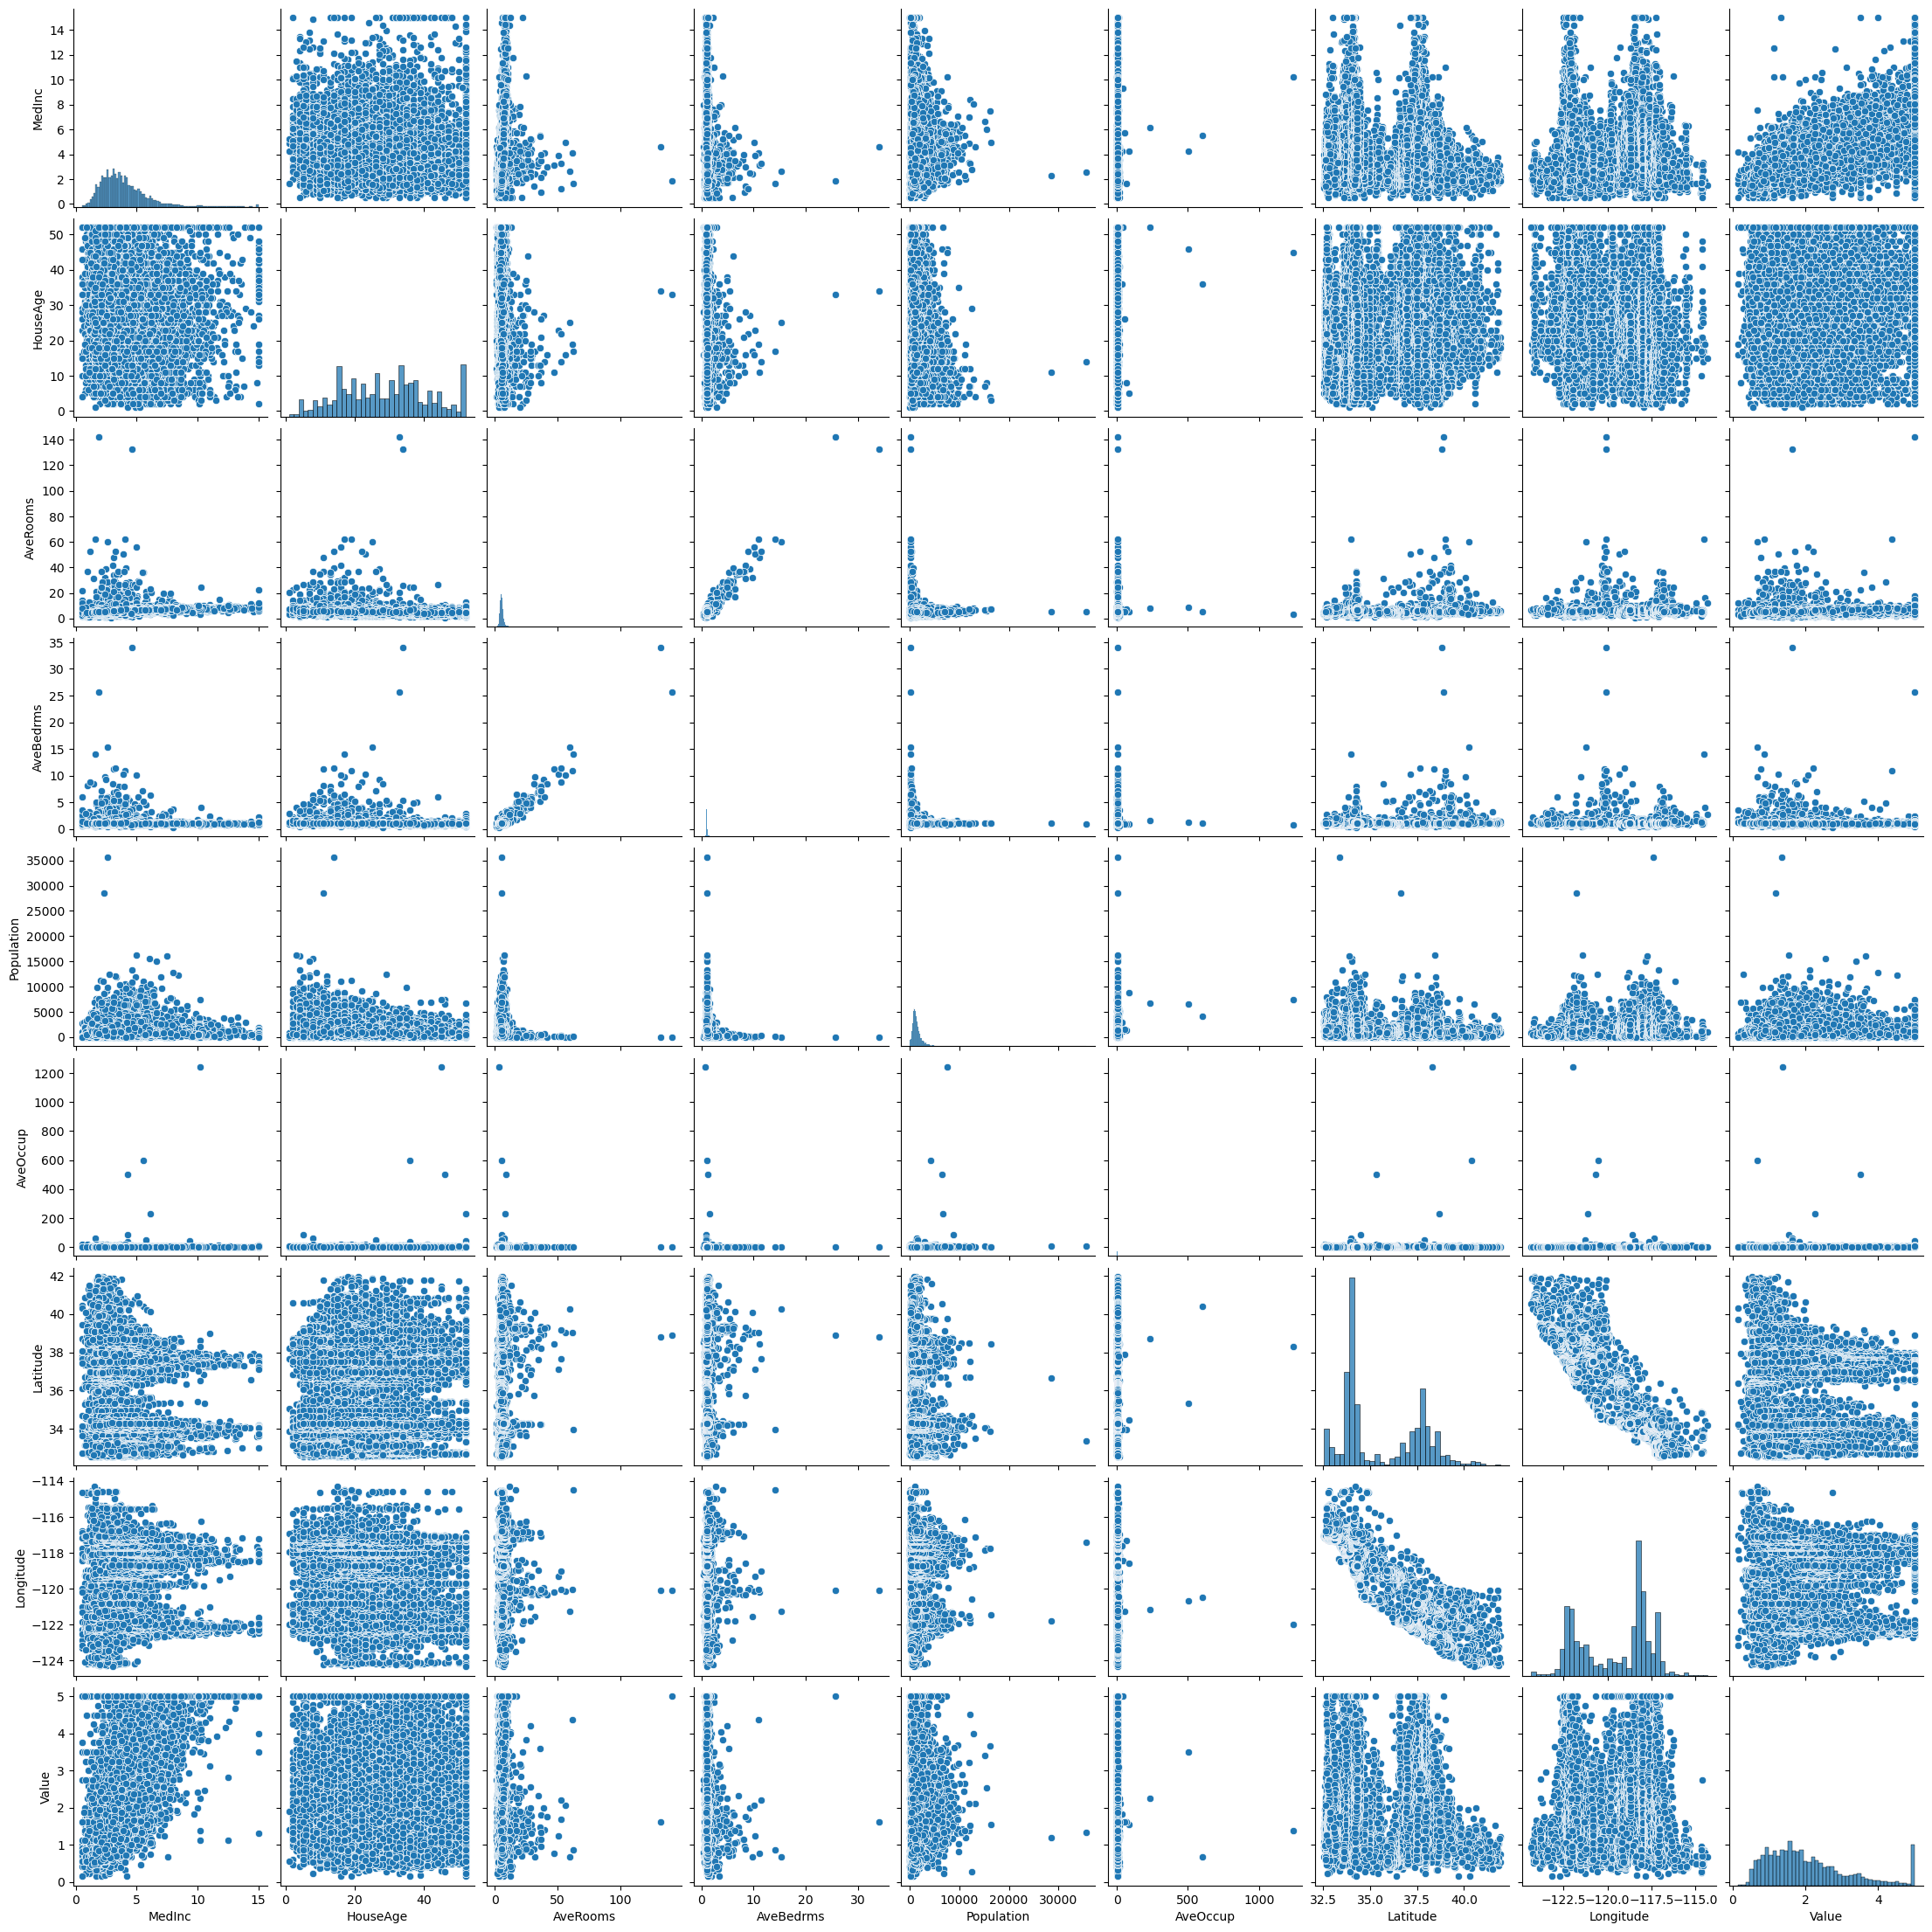

In [87]:
sns.pairplot(df)

In [88]:
analyze_columns(df, include_columns=['Value'])

Skewness of Value: 0.9777632739098345
Kurtosis of Value: 0.3278702429465876


C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [89]:
normality_tests(df['Value'])

Shapiro-Wilk Test: Statistic=0.9123021364212036, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.1029868933808245, p-value=4.7438926919071766e-191
Anderson-Darling Test: Statistic=501.76927817096293
At a significance level of 15.0, the critical value is 0.576.
At a significance level of 10.0, the critical value is 0.656.
At a significance level of 5.0, the critical value is 0.787.
At a significance level of 2.5, the critical value is 0.918.
At a significance level of 1.0, the critical value is 1.092.
Lilliefors Test: Statistic=0.1029858069021079, p-value=0.0009999999999998899
D'Agostino's K-squared Test: Statistic=2430.931051066072, p-value=0.0


C:\Users\Pavilion\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# Features transformation

## log transform

In [90]:
df['AveRooms'] = np.log(df['AveRooms'] + 0.0000001)
df['Population'] = np.log(df['Population'] + 0.0000001)
df['AveOccup'] = np.log(df['AveOccup']+ 0.0000001)

## train-test split

In [91]:
#splitting data for training and testing
X_train, X_test, y_train, y_test= train_test_split(X, y ,test_size=0.1, \
                                                   shuffle = True, random_state=SEED)

## outliers handling

In [92]:
iqr_outlier_remover = IQROutlierRemover(factor=1.5)
X_train_clean, y_train_clean = iqr_outlier_remover.fit_transform(X_train, y_train)
X_test_clean, y_test_clean = iqr_outlier_remover.transform(X_test, y_test)

In [93]:
iqr_outlier_remover.print_outlier_share()

Total share of outliers removed: 19.96%


Spearman's correlation is a non-parametric measure of rank correlation that assesses how well the relationship between two variables can be described using a monotonic function. It evaluates the strength and direction of the association between two ranked variables, making it particularly useful for data that do not meet the assumptions of linear correlation.

## multicollinearity handling

In [94]:
spearman_df = heatmap_spearman_significance(X_train_clean)

In [95]:
X_train_clean_corr, corr_drop = high_corr(X_train_clean, method='spearman', thsld=0.8, perc=0.95)

Removing Longitude with 0.95th percentile = -0.8359108858108424
Remaining columns: Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude'],
      dtype='object')


## feature selection

Lasso is a linear regression technique that includes a penalty equal to the absolute value of the magnitude of coefficients. This penalty can lead to some coefficients being shrunk to zero, effectively selecting a simpler model that includes only a subset of the features.

In [96]:
# Using LassoCV for feature selection
lasso = LassoCV(cv=5, random_state = SEED).fit(X_train_clean_corr, y_train_clean)
lasso_drop = list(X_train_clean_corr.columns[lasso.coef_ == 0])
print("Features dropped by LassoCV:", lasso_drop)

Features dropped by LassoCV: ['AveBedrms']


In [97]:
X_train_clean_corr_lasso = X_train_clean_corr.drop(lasso_drop, axis = 1)
X_test_corr_lasso = X_test_clean.drop(columns = corr_drop + lasso_drop)

## train vs test soundness

C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


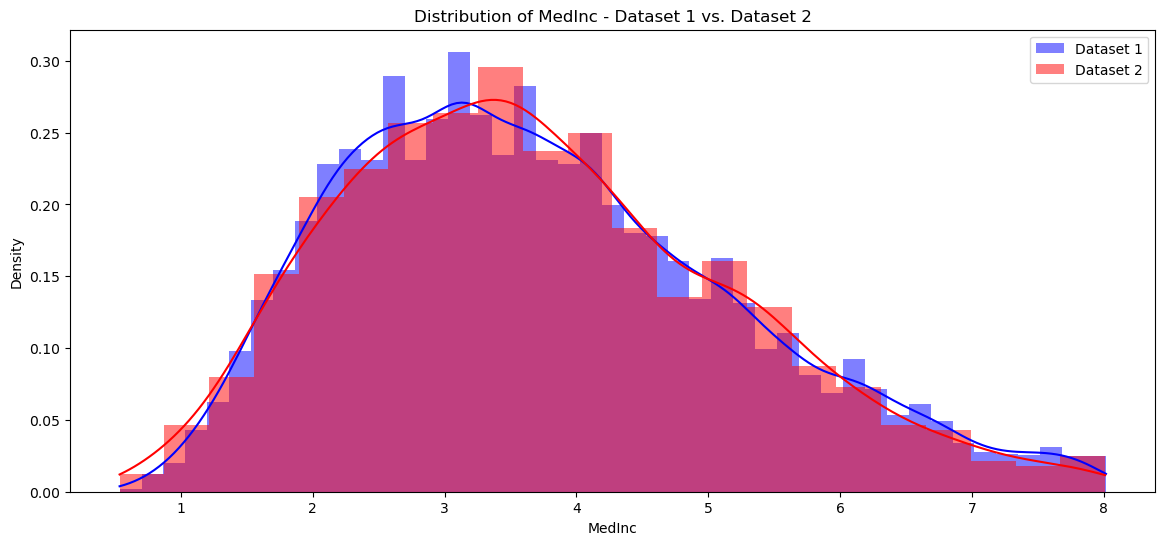

C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


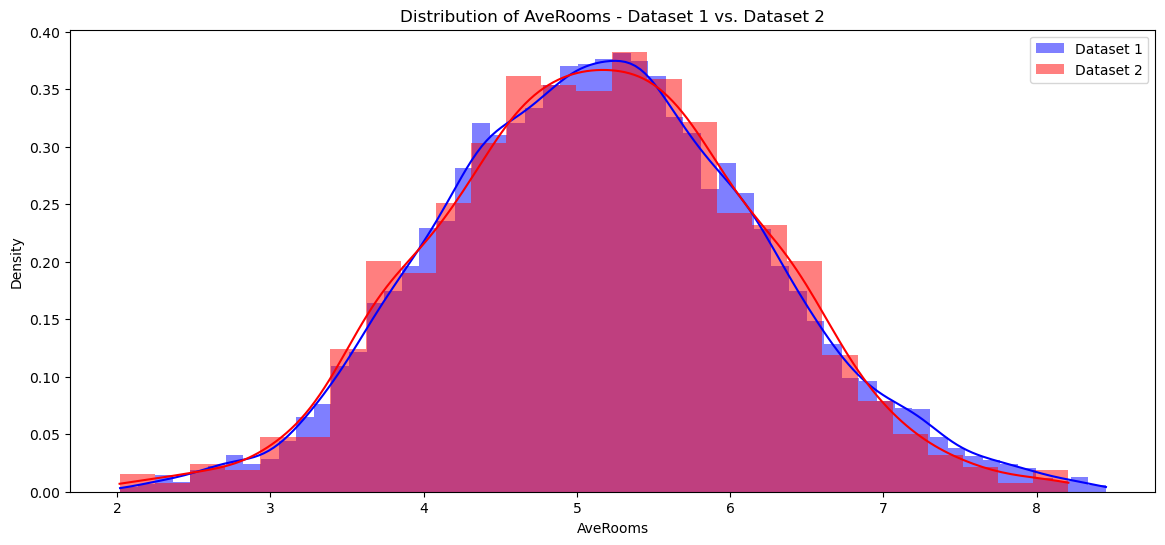

C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


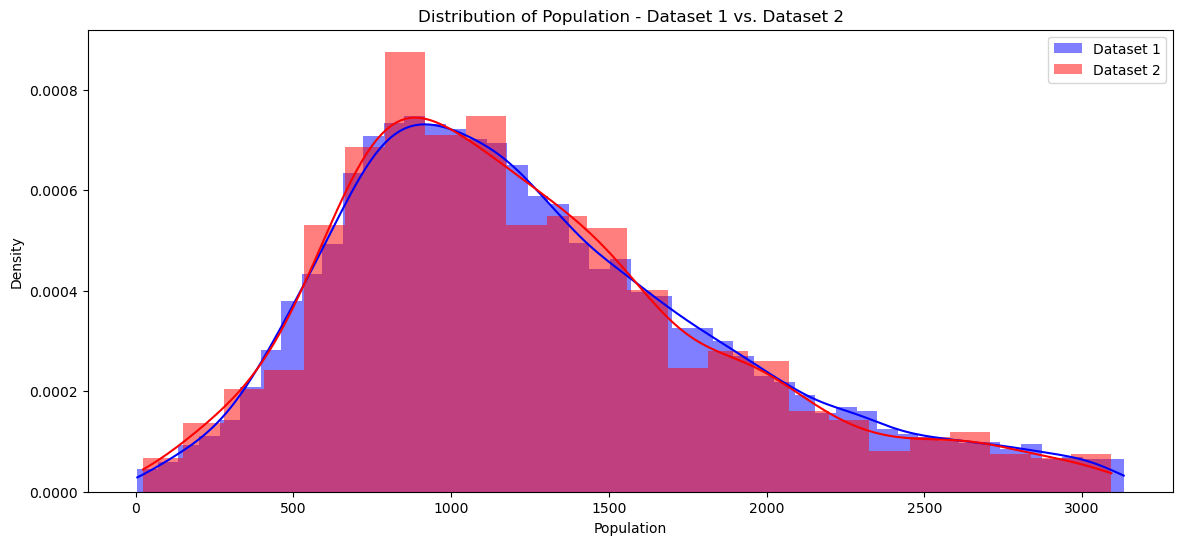

C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


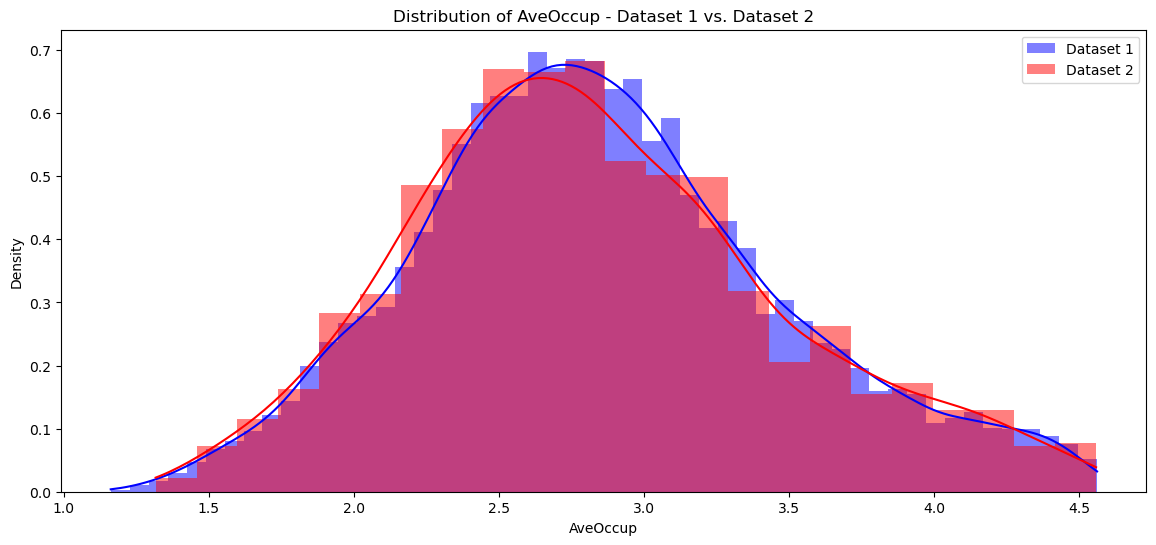

C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


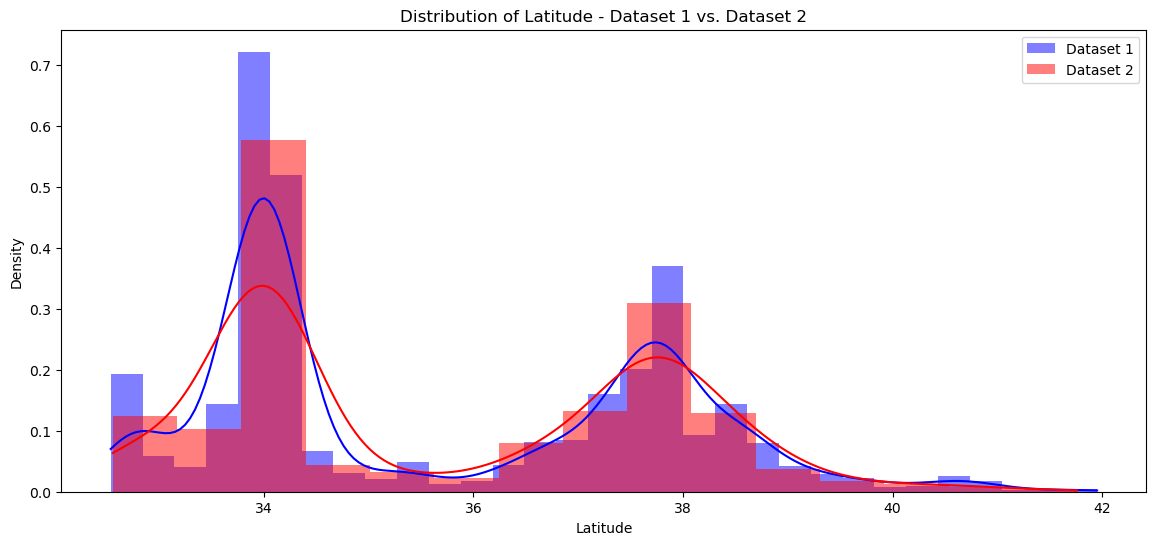

In [98]:
compare_distributions(X_train_clean_corr_lasso, X_test_corr_lasso)

C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


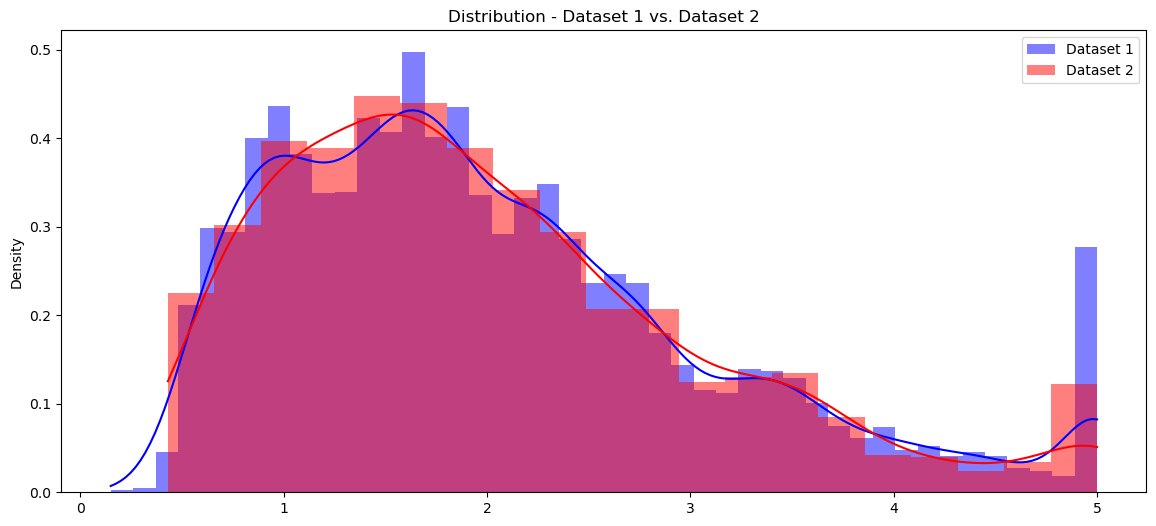

In [99]:
compare_distributions(y_train_clean, y_test_clean)

## normalization

In [100]:
#Normalization
scaler = RobustScaler()
X_train_std = scaler.fit_transform(X_train_clean_corr_lasso)
X_test_std = scaler.transform(X_test_corr_lasso)

# Linear estimators

## Linear regression

Linear regression is a statistical method for modeling the relationship between a dependent variable and one or more independent variables by fitting a linear equation to observed data. The coefficients of the equation are derived from the data to minimize the sum of the squared differences between the observed and predicted values.

In [101]:
linreg = LinearRegression()
linreg.fit(X_train_std, y_train_clean)
y_pred = linreg.predict(X_test_std)
y_pred_train = linreg.predict(X_train_std)
residuals = y_test_clean - y_pred
residuals_train = y_train_clean - y_pred_train
mean_squared_error(y_test_clean, y_pred)

0.44091664056394475

In [102]:
linreg_results = test_regression(linreg, X_train_std, X_test_std, y_train_clean, y_test_clean, 5)
linreg_results

{'train_mse': [0.49200467329433206],
 'test_mse': [0.44091664056394475],
 'train_mae': [0.5270895721552269],
 'test_mae': [0.5034339465812194],
 'train_mape': [32.16678009571623],
 'test_mape': [30.705239333052305],
 'train_r2': [0.5743508157579602],
 'test_r2': [0.5943011417426579]}

In [103]:
# Initialize the OLS wrapper
ols = StatmodelsWrapper()
ols_results = test_regression(ols, X_train_std, X_test_std, y_train_clean, y_test_clean, 5)
display(ols_results)
ols.summary()

{'train_mse': [0.4920046732943321],
 'test_mse': [0.4409166405639447],
 'train_mae': [0.5270895721552268],
 'test_mae': [0.5034339465812193],
 'train_mape': [32.1667800957162],
 'test_mape': [30.705239333052265],
 'train_r2': [0.5743508157579602],
 'test_r2': [0.594301141742658]}

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     3412.
Date:                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:02:53   Log-Likelihood:                -16150.
No. Observations:               15180   AIC:                         3.231e+04
Df Residuals:                   15173   BIC:                         3.237e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0068      0.007    276.950      0.000       1.993       2.021
x1             1.2007      0.012    102.253      0.000       1.178       1.224
x2             0.3567      0.009     37.708      0.000       0.338       0.375
x3            -0.3292      0.012    -28.104      0.000      -0.352      -0.306
x4             0.1039      0.008     12.872      0.000       0.088       0.120
x5            -0.3988      0.008    -51.345      0.000      -0.414      -0.384
x6            -0.1790      0.011    -16.692      0.000      -0.200      -0.158
==============================================================================
Omnibus:                     2245.800   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4513.420
Skew:                           0.911   Prob(JB):                         0.00
Kurtosis:                       4.953   Cond. No.                         3.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* R-squared: The coefficient of determination, a measure of how well the model's predictions match the observed data. Share of variance in target variable, which is explained by the model. 
* Adj. R-squared: An adjusted version of R-squared that accounts for the number of predictors in the model. 
* F-statistic: A measure of the overall significance of the model; it compares the model with and without predictors. Higher values indicate that the model fits the data better than a model without any predictors.
* Prob (F-statistic): The p-value for the F-statistic, indicating the probability that the observed results could occur under the null hypothesis.A small p-value (typically < 0.05) suggests the model is statistically significant.
* Log-Likelihood: The natural logarithm of the likelihood function for the fitted model.igher values are better, indicating a model that better fits the data.
* AIC: Akaike’s Information Criterion, balances the model's fit with the number of parameters to prevent overfitting.Lower values are preferred, indicating a more parsimonious model.
* BIC: Bayesian Information Criterion, similar to AIC, but with a higher penalty for models with more parameters.Lower values are preferred, indicating a more parsimonious model.

### Assumptions testing

#### Linear relarionship

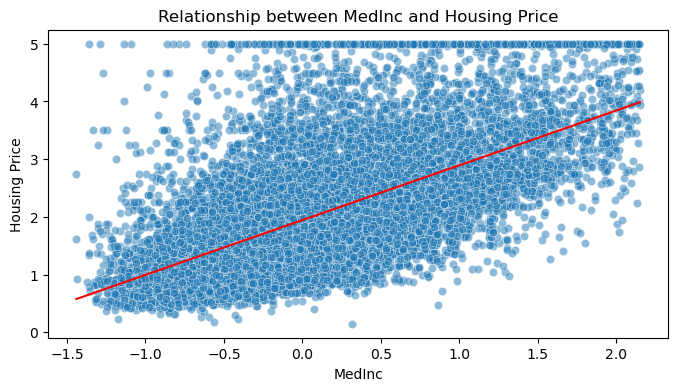

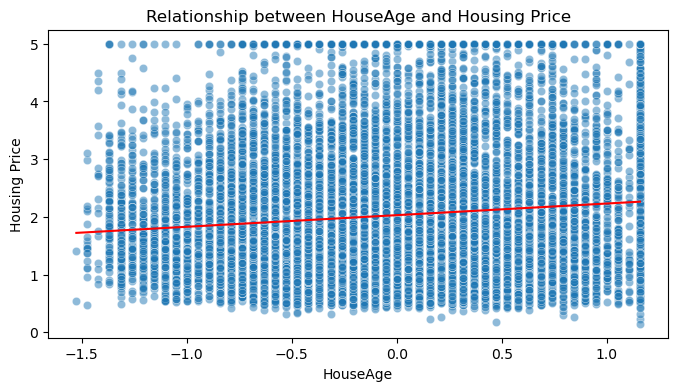

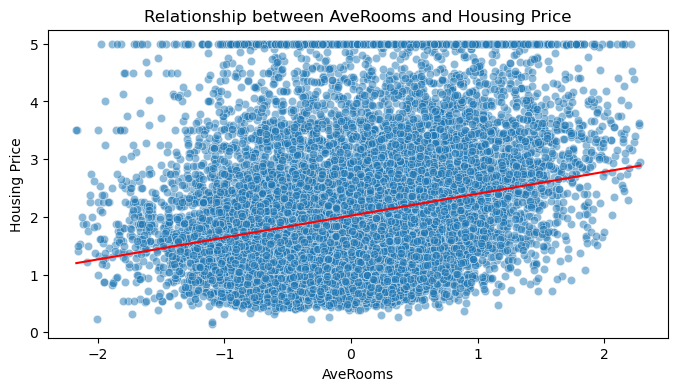

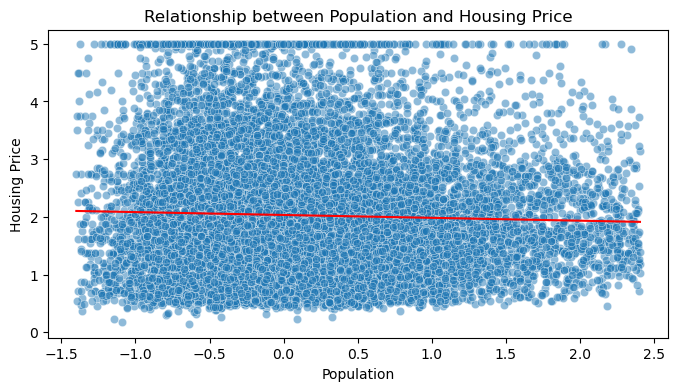

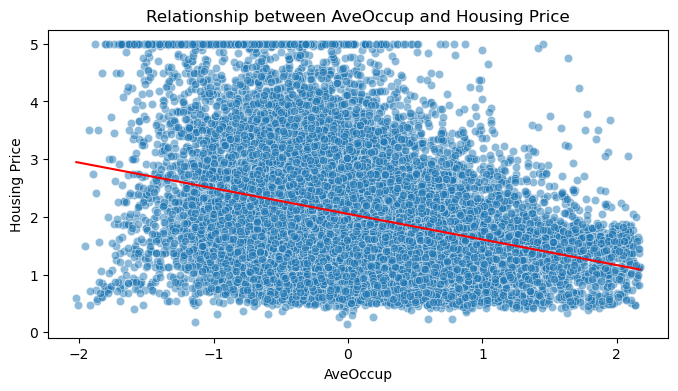

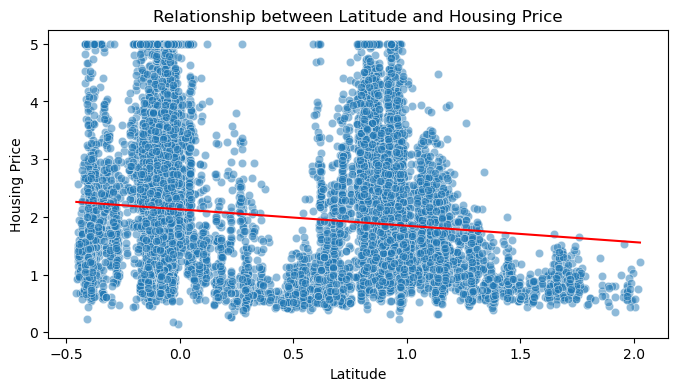

In [104]:
scaled_df = pd.DataFrame(X_train_std, index=X_train_clean_corr_lasso.index, columns=X_train_clean_corr_lasso.columns)

for column in scaled_df.columns:
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(scaled_df[column], y_train_clean)

    # Create scatter plot
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=scaled_df, x=column, y=y_train_clean, alpha=0.5)

    # Calculate values for the fitted line
    x_values = np.linspace(scaled_df[column].min(), scaled_df[column].max(), 100)
    y_values = slope * x_values + intercept

    # Plot the fitted line
    plt.plot(x_values, y_values, color='red')

    # Add title and labels
    plt.title(f'Relationship between {column} and Housing Price')
    plt.xlabel(column)
    plt.ylabel('Housing Price')

    # Show the plot
    plt.show()

* High Correlation: A high absolute value of the correlation coefficient indicates a strong linear relationship.

* P-value: A small p-value (typically <0.05) suggests that the observed correlation is statistically significant.

#### Normal distribution of residuals

((array([-3.91256313, -3.69294965, -3.57262769, ...,  3.57262769,
          3.69294965,  3.91256313]),
  array([-2.95003562, -2.65212095, -2.40621551, ...,  3.75067972,
          4.06772433,  4.19504941])),
 (0.6865614249309305, 1.6498846812158712e-16, 0.9789281937126039))

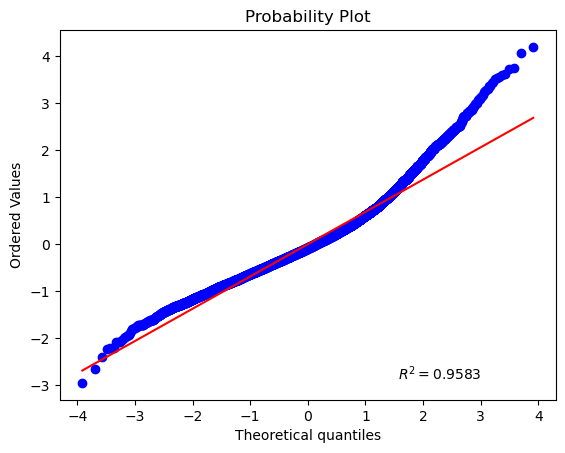

In [105]:
stats.probplot(residuals_train, plot=plt, rvalue = True)

Based on the R2 value, you can analyze how well your data fits the normal distribution. 
A high(e.g., > 0.95) suggests a good fit, implying that the data is likely normally distributed, 
while a lower suggests a poorer fit.

C:\Users\Pavilion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


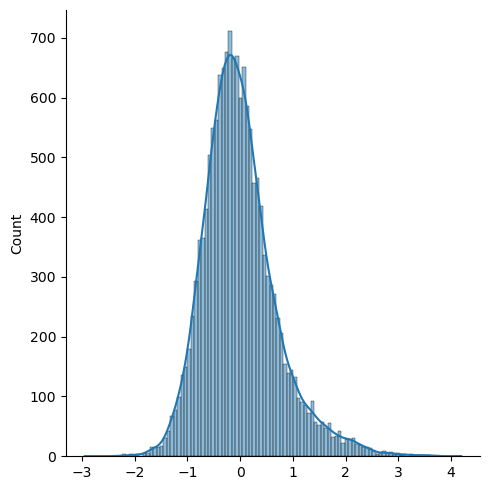

In [106]:
sns.displot(residuals_train, kde=True)

There is multiple test to assess distrubution of a population.
H0 - normal distribution of residuals.

H0 is rejected when p-values < 0.05.

In [107]:
normality_tests(residuals_train)

Shapiro-Wilk Test: Statistic=0.958405077457428, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.06565733687673037, p-value=2.4459254065395093e-57
Anderson-Darling Test: Statistic=138.8010092752229
At a significance level of 15.0, the critical value is 0.576.
At a significance level of 10.0, the critical value is 0.656.
At a significance level of 5.0, the critical value is 0.787.
At a significance level of 2.5, the critical value is 0.918.
At a significance level of 1.0, the critical value is 1.092.
Lilliefors Test: Statistic=0.06566109261334563, p-value=0.0009999999999998899
D'Agostino's K-squared Test: Statistic=2245.8001294272026, p-value=0.0


C:\Users\Pavilion\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Homoscedasticity

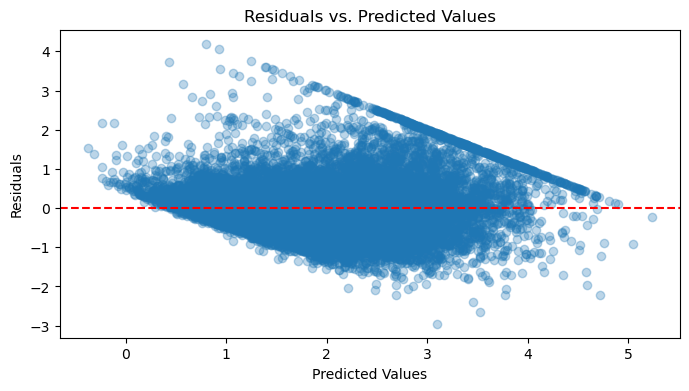

In [108]:
# Residuals vs Predicted values
plt.figure(figsize=(8, 4))
plt.scatter(y_pred_train, residuals_train, alpha = 0.3)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

* White's Test Statistic: A larger statistic suggests potential problems with heteroscedasticity.

* p-value: A small p-value (e.g., less than 0.05) indicates evidence against the null hypothesis of homoscedasticity, suggesting the presence of heteroscedasticity.

In [109]:
X_const = sm.add_constant(scaled_df)
white_test = het_white(residuals_train, X_const)
white_test_statistic, white_test_pvalue = white_test[:2]

print(f"White's Test Statistic: {white_test_statistic}")
print(f"White's Test p-value: {white_test_pvalue}")

White's Test Statistic: 1512.8434848718773
White's Test p-value: 1.7735952763309463e-302


#### Autocorrelation of residuals

The Durbin-Watson test is a statistical test used to detect the presence of autocorrelation (a relationship between values separated from each other by a given time lag) at lag 1 in the residuals (prediction errors) from a regression analysis.The test statistic ranges from 0 to 4.

* A value of 2 indicates no autocorrelation.
* A value approaching 0 indicates positive autocorrelation.
* A value approaching 4 indicates negative autocorrelation.

In [110]:
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw}')

Durbin-Watson statistic: 1.9944626788563347


#### Milticollinearity

The Variance Inflation Factor (VIF) is a measure that quantifies the extent of multicollinearity in an ordinary least squares regression analysis. Multicollinearity occurs when two or more predictor variables in a regression model are highly correlated, meaning that one can be linearly predicted from the others with a substantial degree of accuracy. 
* VIF = 1: No correlation between the independent variable and the other variables.
* 1 < VIF < 5: Generally, a moderate correlation, and often not of concern.
* VIF >= 5: Indicates high multicollinearity (some sources may use 10 as the threshold), and the variable's coefficients may be poorly estimated due to the redundancy with other predictors.

In [111]:
vif_data = pd.DataFrame()
vif_data["feature"] = scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(scaled_df.values, i) for i in range(len(scaled_df.columns))]
print(vif_data)

      feature   VIF
0      MedInc 2.038
1    HouseAge 1.146
2    AveRooms 2.150
3  Population 1.182
4    AveOccup 1.102
5    Latitude 1.044


### Coefficients

In [112]:
linreg_p_values(linreg, scaled_df, y_train_clean)

C:\Users\Pavilion\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Predictor   coef  t-stat  p-values
0      MedInc  1.201 150.662     0.000
1    HouseAge  0.357  41.113     0.000
2    AveRooms -0.329 -42.665     0.000
3  Population  0.104  13.936     0.000
4    AveOccup -0.399 -54.544     0.000
5    Latitude -0.179 -19.487     0.000

Each standardized coefficient represents the change in the dependent variable, in standard deviations, for a one standard deviation increase in the predictor variable, holding all other predictors constant.

Because all predictors are on the same scale, standardized coefficients allow for direct comparison of the magnitude of the effect that each predictor has on the dependent variable.

In [113]:
std_coefs = linreg.coef_
std_incpt = linreg.intercept_
orig_coefs = std_coefs / scaler.scale_
orig_incpt = std_incpt

# Create a DataFrame with the original coefficients
df_coefs = pd.DataFrame({'Name': scaled_df.columns, 'True coef': orig_coefs})
df_coefs

Name  True coef
0      MedInc      0.577
1    HouseAge      0.019
2    AveRooms     -0.228
3  Population      0.000
4    AveOccup     -0.492
5    Latitude     -0.047

True coefficients represent the estimated change in the dependent variable for a one-unit increase in the independent variable, holding all other independent variables constant..

## Elastic Net

Elastic Net is a regularization technique used in linear regression that combines both L1 and L2 penalties of the Lasso and Ridge methods. It is useful when there are multiple correlated features; it tends to select groups of correlated variables and shrink less important features fully to zero.

In [114]:
param_grid = {
    'alpha': np.logspace(-4, 4, 10),  
    'l1_ratio': np.linspace(0.01, 1.0, 10)  
}

grid = GridSearchCV(estimator=ElasticNet(max_iter=10000, random_state = SEED), param_grid=param_grid,
                    cv=5, scoring='neg_mean_squared_error')
grid.fit(scaled_df, y_train_clean)

print("Best parameters:", grid.best_params_)
print("Best score MSE:", -grid.best_score_) 

Best parameters: {'alpha': 0.0001, 'l1_ratio': 0.01}
Best score MSE: 0.4920046461594601


In [115]:
elastic_net = grid.best_estimator_
elastic_net_results = test_regression(elastic_net, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
elastic_net_results

C:\Users\Pavilion\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


{'train_mse': [0.49200464615946],
 'test_mse': [0.4409154020969817],
 'train_mae': [0.5270891982552646],
 'test_mae': [0.5034384984391621],
 'train_mape': [32.16762196934806],
 'test_mape': [30.705726261110545],
 'train_r2': [0.5743507416593523],
 'test_r2': [0.5943022812882923]}

## SVR

SVR is a type of Support Vector Machine (SVM) that is used for regression problems. It works by fitting the best line within a threshold value where the distances from the closest points of the data set (known as support vectors) to this line are minimized.

The linear kernel does not involve any transformation to a higher-dimensional space. It is suitable for linearly separable data.

In [116]:
#Linear regressor
svr_lin = SVR(kernel='linear')
svr_lin_results = test_regression(svr_lin, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
svr_lin_results

C:\Users\Pavilion\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


{'train_mse': [0.5064207475397491],
 'test_mse': [0.4494081688786695],
 'train_mae': [0.5193810188562307],
 'test_mae': [0.4936500328763591],
 'train_mape': [29.777977411272456],
 'test_mape': [28.351038210076013],
 'train_r2': [0.5618950422933519],
 'test_r2': [0.5864878658868465]}

## WLS

WLS is a variant of linear regression that assigns different weights to different data points. It is particularly useful when the residuals (errors) have non-constant variance, allowing for a better fit by giving less weight to points with higher variance.

In [117]:
# Initialize the WLS wrapper
wls = StatmodelsWrapper(use_wls=True)
wls_results = test_regression(wls, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
display(wls_results)
wls.summary()

{'train_mse': [0.49201239885776243],
 'test_mse': [0.44089942293283013],
 'train_mae': [0.527081121329649],
 'test_mae': [0.5034095482579396],
 'train_mape': [32.16592288707177],
 'test_mape': [30.703200633406336],
 'train_r2': [0.5743507330463927],
 'test_r2': [0.5943169841324487]}

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.192e+07
Date:                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:03:27   Log-Likelihood:                -4967.9
No. Observations:               15180   AIC:                             9950.
Df Residuals:                   15173   BIC:                         1.000e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0066      0.000   1.64e+04      0.000       2.006       2.007
MedInc         1.2008      0.000   5225.201      0.000       1.200       1.201
HouseAge       0.3564      0.000   2429.214      0.000       0.356       0.357
AveRooms      -0.3293      0.000  -1781.047      0.000      -0.330      -0.329
Population     0.1037      0.000    691.348      0.000       0.103       0.104
AveOccup      -0.3988      0.000  -2988.917      0.000      -0.399      -0.399
Latitude      -0.1786      0.000   -881.420      0.000      -0.179      -0.178
==============================================================================
Omnibus:                    53655.762   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2528.871
Skew:                           0.218   Prob(JB):                         0.00
Kurtosis:                       1.049   Cond. No.                         15.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Huber

Huber Regression is a robust regression technique that is less sensitive to outliers in data. It combines the properties of both ridge regression and least squares, adjusting the loss function to reduce the weight given to outliers in the fitting process.

Hyperparameters:
*  'epsilon' determines the threshold at which the loss function changes from a quadratic to a linear form. For differences between the predicted and actual values less than ε, the loss is quadratic; for differences greater than ε, the loss becomes linear. A common starting value for ε is 1.35, which has theoretical justifications in terms of achieving high efficiency for normally distributed errors.

* 'alpha' parameter is used as a regularization term (similar to Ridge or Lasso regression). It controls the strength of the L2 regularization on the coefficients. A value of 0 implies no regularization, and larger values imply stronger regularization.

In [118]:
# Create and fit the Huber regressor
huber = HuberRegressor(alpha=0.001, epsilon=1.35)
huber_results = test_regression(huber, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
huber_results

C:\Users\Pavilion\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but HuberRegressor was fitted with feature names
  warnings.warn(


{'train_mse': [0.5009271622210766],
 'test_mse': [0.44511461064650415],
 'train_mae': [0.5197347709352798],
 'test_mae': [0.49437579127217196],
 'train_mape': [30.21130248866698],
 'test_mape': [28.77592762374609],
 'train_r2': [0.5665469609695286],
 'test_r2': [0.5904384803849134]}

# Non-linear estimators

## Polynominal Regression

Polynomial regression is a form of linear regression in which the relationship between the independent variable x and the dependent variable y is modeled as an nth degree polynomial. It is used for fitting non-linear relationships in data.

In [119]:
for i in range(1, 7):
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=i, include_bias=False)
    X_poly_train = poly_features.fit_transform(scaled_df)

    # Fit the model
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_poly_train, y_train_clean)

    # Ensure X_test_std is a DataFrame with the same feature names as scaled_df
    X_test_std_df = pd.DataFrame(X_test_std, columns=scaled_df.columns)

    # Predict on transformed test data
    X_poly_test = poly_features.transform(X_test_std_df)
    y_pred = poly_reg_model.predict(X_poly_test)

    # Calculate and print the mean squared error
    mse = mean_squared_error(y_test_clean, y_pred)
    print(f"Mean squared error for degree {i}: {mse}")


Mean squared error for degree 1: 0.44091664056394486
Mean squared error for degree 2: 0.38722824283554425
Mean squared error for degree 3: 0.36483885316358866
Mean squared error for degree 4: 0.357065711541891
Mean squared error for degree 5: 0.3529902806326451
Mean squared error for degree 6: 0.43588758677461376


In [120]:
# Create polynomial features
poly_features = PolynomialFeatures(degree=5, include_bias=True)
X_train_std_poly = poly_features.fit_transform(scaled_df)
X_test_std_poly = poly_features.transform(X_test_std)

# Fit the model
linreg_poly_results = test_regression(linreg, X_train_std_poly, X_test_std_poly, y_train_clean, y_test_clean, 5)
linreg_poly_results

C:\Users\Pavilion\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


{'train_mse': [0.3785822824348025],
 'test_mse': [0.35299028063264454],
 'train_mae': [0.4223586303181246],
 'test_mae': [0.430203462382948],
 'train_mape': [24.768627882762832],
 'test_mape': [25.60419196545699],
 'train_r2': [0.7051003594284855],
 'test_r2': [0.675204470292988]}

## SVR

SVR is a type of Support Vector Machine (SVM) that is used for regression problems. It works by fitting the best line within a threshold value where the distances from the closest points of the data set (known as support vectors) to this line are minimized.

The RBF kernel can handle non-linear relationships by mapping input features into a higher-dimensional space in a non-linear fashion. It is very flexible and can create complex decision boundaries.

In [121]:
#Non-linear regressor
svr_rbf = SVR(kernel='rbf') 
svr_rbf_results = test_regression(svr_rbf, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
svr_rbf_results

C:\Users\Pavilion\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


{'train_mse': [0.3807256298717173],
 'test_mse': [0.3457686581414021],
 'train_mae': [0.41870646256576477],
 'test_mae': [0.4114551303939176],
 'train_mape': [23.527349684556455],
 'test_mape': [23.240571186449177],
 'train_r2': [0.6862092526428523],
 'test_r2': [0.6818492728019504]}

## Regression Tree

 A regression tree represents decisions and decision making in a tree-like model of decisions and their possible consequences.Hyperparameters:
* criterion='squared_error': The function used to measure the quality of a split. The default is the mean squared error, which is suitable for regression tasks. Other options include friedman_mse (Friedman's mean squared error) and absolute_error for mean absolute error.

* splitter='best': The strategy used to choose the split at each node. The default value 'best' means that the best split is chosen. Another option is 'random', which chooses the best random split.

* max_depth=None: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

* min_samples_split=2: The minimum number of samples required to split an internal node. If an integer is provided, it is the minimum number; if a float, it represents a fraction of the total number of samples.

* min_samples_leaf=1: The minimum number of samples required to be at a leaf node. Similar to 
 min_samples_split, this can be an integer or a float.

* min_weight_fraction_leaf=0.0: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.

* max_features=None: The number of features to consider when looking for the best split. If None, then max_features=n_features.

* random_state=None: Controls the randomness of the estimator. The features are always randomly permuted at each split, even if the splitter is set to 'best'. When random_state is an integer, it ensures consistent results across multiple runs.

* max_leaf_nodes=None: Grow a tree with max_leaf_nodes in best-first fashion if not None. Best nodes are defined as relative reduction in impurity.

* min_impurity_decrease=0.0: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

* ccp_alpha=0.0: Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.

In [122]:
tree_reg = DecisionTreeRegressor(min_samples_split = 20, random_state = SEED)
tree_reg_results = test_regression(tree_reg, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
tree_reg_results

C:\Users\Pavilion\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


{'train_mse': [0.5186159926893052],
 'test_mse': [0.5246735876777939],
 'train_mae': [0.27839678714881205],
 'test_mae': [0.488991413883251],
 'train_mape': [15.39447367465096],
 'test_mape': [27.381967420317693],
 'train_r2': [0.8554864278481547],
 'test_r2': [0.5172341982683819]}

## Gradiest boost

GradientBoostingRegressor builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions, making it highly flexible.
Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. 

Main Hyperparameters:
* n_estimators:The number of boosting stages or trees to be added to the model. More trees can improve the model's performance but can also lead to overfitting.

* learning_rate: This parameter scales the contribution of each tree. A smaller learning rate requires more trees in the ensemble to maintain model complexity.

* max_depth:The maximum depth of the individual regression estimators. It controls how deep each tree can grow and thus the complexity of the model.

* min_samples_split: The minimum number of samples required to split an internal node. This parameter can affect the number of splits in each tree and thus the complexity of the model.

* min_samples_leaf: The minimum number of samples required to be at a leaf node. Setting this parameter can help with smoothing the model, especially in regression.

* max_features: The number of features to consider when looking for the best split. This can impact both the performance and training speed of the model.

* subsample:The fraction of samples to be used for fitting each individual base learner. Using a value less than 1.0 introduces more randomness into the model and can help prevent overfitting.

In [123]:
gbr = GradientBoostingRegressor(learning_rate=0.1, min_samples_split = 20, random_state = SEED)
gbr_results = test_regression(gbr, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
gbr_results

C:\Users\Pavilion\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


{'train_mse': [0.36552030976563266],
 'test_mse': [0.33741853619123036],
 'train_mae': [0.4225299741007934],
 'test_mae': [0.4192945380735662],
 'train_mape': [24.916794029142306],
 'test_mape': [24.8282674945461],
 'train_r2': [0.7089324661993848],
 'test_r2': [0.6895324369872744]}

## AdaBoost

AdaBoost, short for Adaptive Boosting, is an ensemble learning method that is used to boost the performance of decision trees. It works by combining multiple weak learners into a single strong learner. The key principle behind AdaBoost is to adjust the weights of incorrectly classified instances so that subsequent estimators focus more on difficult cases.

Hyperparameters: 
* base_estimator:Description: The model to use as the weak learners. By default, AdaBoost uses a Decision Stump (a one-level Decision Tree).

* n_estimators:Description: The maximum number of weak learners to train. Increasing this number can improve the model but also increase the risk of overfitting.

* learning_rate: This parameter scales the contribution of each weak learner. There is a trade-off between learning_rate and n_estimators.

* algorithm:Specifies the algorithm to use. The two options are SAMME and SAMME.R. SAMME.R uses the probability estimates to update the additive model, while SAMME uses the classifications.

* random_state: Controls the randomness of the bootstrap sampling used to train the weak learners. Ensuring a consistent random_state across runs can be useful for reproducibility.

In [124]:
adb = AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state = SEED)
adb_results = test_regression(adb, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
adb_results

C:\Users\Pavilion\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


{'train_mse': [0.5472232979239257],
 'test_mse': [0.5203808318848828],
 'train_mae': [0.5832099953489889],
 'test_mae': [0.5789412280394172],
 'train_mape': [41.07062160163942],
 'test_mape': [40.986031122405],
 'train_r2': [0.5356328622483224],
 'test_r2': [0.5211840744212396]}

## XGBoost

XGBoost (Extreme Gradient Boosting) is an advanced implementation of the gradient boosting algorithm that enhances the standard boosting method by introducing regularization to reduce overfitting, and by employing sophisticated optimization techniques for faster learning.

* booster: The type of model to run at each iteration. Choices include gbtree (tree-based models), gblinear (linear models), and dart (Dropouts meet Multiple Additive Regression Trees).

* 8eta (also known as learning_rate in the scikit-learn API): Step size shrinkage used to prevent overfitting. 

* max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

* min_child_weight: Minimum sum of instance weight (hessian) needed in a child. Higher values prevent the model from learning relations which might be highly specific to the particular sample selected for a tree.

* gamma (also known as min_split_loss): Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger the value, the more conservative the algorithm will be.

* objective: The loss function to be minimized. Examples include reg:squarederror for regression tasks, binary:logistic for binary classification, multi:softmax for multiclass classification, etc.

* eval_metric: The metric to be used for validation data. The default values are rmse for regression and error for classification.

* lambda (also known as reg_lambda): L2 regularization term on weights. Increasing this value will make the model more conservative.

* alpha (also known as reg_alpha): L1 regularization term on weights. Can be used in case of very high dimensionality so that the algorithm runs faster when implemented.

* n_estimators: Number of gradient boosted trees. Equivalent to the number of boosting rounds.

In [125]:
xgb_reg = XGBRegressor(objective = 'reg:squarederror', eta = 0.1, n_estimators=100, random_state = SEED)
xgb_results = test_regression(xgb_reg, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
xgb_results

{'train_mse': [0.3276148637118427],
 'test_mse': [0.29991197367900546],
 'train_mae': [0.340522368974484],
 'test_mae': [0.38754884892476965],
 'train_mape': [19.920450300958006],
 'test_mape': [22.46740256328908],
 'train_r2': [0.8060961388815071],
 'test_r2': [0.724043199767525]}

## Random Forest

Random Forest Regressor is an ensemble learning method that operates by constructing multiple decision trees during training and outputting the mean prediction of the individual trees for regression tasks. 

:
* n_estimators: The number of trees in the forest.

* max_depth:The maximum depth of each tree. Deeper trees can capture more complex patterns but might lead to overfitting.

* min_samples_split:Description: The minimum number of samples required to split an internal node.

* min_samples_leaf:The minimum number of samples required to be at a leaf node.

* max_features:The number of features to consider when looking for the best split.

* bootstrap: Whether bootstrap samples are used when building trees.

In [126]:
rf = RandomForestRegressor(min_samples_leaf=20, random_state=SEED)
rf_results = test_regression(rf, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
rf_results

C:\Users\Pavilion\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


{'train_mse': [0.36381691854841736],
 'test_mse': [0.34224227872735696],
 'train_mae': [0.3762559857676826],
 'test_mae': [0.41382146439859313],
 'train_mape': [21.842446447670262],
 'test_mape': [23.9712309292473],
 'train_r2': [0.7551353543221779],
 'test_r2': [0.6850939861342267]}

## LBGM

LightGBM is based on gradient boosting, an ensemble technique that builds models sequentially, with each new model correcting errors made by previously trained models.Unlike traditional decision tree algorithms that evaluate every possible split, LightGBM uses a histogram-based algorithm that buckets continuous feature values into discrete bins. 

Hyperparameters:
* task: Specifies the task you want to perform, which can be either 'train' for training or 'predict' for predictions.

* boosting_type: Specifies the type of algorithm to run. Common options include 'gbdt' (traditional Gradient Boosting Decision Tree), 'dart' (Dropouts meet Multiple Additive Regression Trees), 'goss' (Gradient-based One-Side Sampling), and 'rf' (Random Forest).

* objective: Specifies the learning task and the corresponding learning objective. Examples include 'regression', 'binary', 'multiclass', 'lambdarank', and more, depending on whether you're dealing with regression, binary classification, multi-class classification, or ranking tasks.

* metric: Specifies the evaluation metrics to be used for model assessment during training. Examples include 'rmse', 'mae', 'logloss', 'error' (for classification), 'auc' (for binary classification), etc.

* learning_rate: Determines the step size at each iteration while moving toward a minimum of a loss function. Smaller values make the learning slower but can lead to better performance.

* num_leaves: Sets the maximum number of leaves in one tree. More leaves will increase the model's complexity but might lead to overfitting.

* max_depth: Limits the maximum depth of the tree to prevent overfitting. Setting it to -1 means no limit.

* min_data_in_leaf: Minimum number of data points allowed in a leaf. This can smooth the model, especially for regression.

* feature_fraction: Used for randomly selecting a subset of features on each iteration to prevent overfitting.

* bagging_fraction and bagging_freq: Control bagging (bootstrap aggregating) by randomly selecting part of the data without resampling at each iteration to speed up training and reduce overfitting.

* lambda_l1 and lambda_l2: These parameters specify L1 and L2 regularization terms on weights to prevent overfitting.

* max_bin: Maximum number of bins that feature values will be bucketed in. A smaller value might improve training efficiency but could lead to underfitting.

* num_iterations: Specifies the number of boosting iterations to be run, similar to the number of trees in RandomForest.

* early_stopping_rounds: Allows the model to stop training if the validation score stops improving for a specified number of rounds.

In [127]:
lgbm = LGBMRegressor(objective = 'regression', learning_rate=0.05, min_data_in_leaf=20, random_state = SEED)
lgbm_results = test_regression(lgbm, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
lgbm_results

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1326
[LightGBM] [Info] Number of data points in the train set: 15180, number of used features: 6
[LightGBM] [Info] Start training from score 2.027066
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


{'train_mse': [0.3301492948249784],
 'test_mse': [0.30358847486692814],
 'train_mae': [0.38057230340762277],
 'test_mae': [0.39375929372303226],
 'train_mape': [22.519715666390038],
 'test_mape': [23.264968247098547],
 'train_r2': [0.7600654787733814],
 'test_r2': [0.7206603554901707]}

## KNN

KNN regression predicts the value for a new data point by averaging the values of the K nearest neighbors in the training set. 

In [128]:
knn = KNeighborsRegressor(n_neighbors=20)
knn_results = test_regression(knn, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
knn_results

C:\Users\Pavilion\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


{'train_mse': [0.3975677826905571],
 'test_mse': [0.3645297774754385],
 'train_mae': [0.4346924511528326],
 'test_mae': [0.4408305956416465],
 'train_mape': [26.047676716656277],
 'test_mape': [26.531814460742893],
 'train_r2': [0.6914042510831087],
 'test_r2': [0.6645866793926539]}

## CatBoost

CatBoost (Categorical Boosting) is an efficient, gradient boosting-based learning algorithm that is particularly designed to handle categorical features seamlessly and reduce overfitting, which is common in decision-tree-based models. It transforms categorical variables into numerical values using various statistics on combinations of categorical features and the target variable, without the need for explicit pre-processing. CatBoost improves upon traditional gradient boosting methods by implementing an “ordered” boosting scheme.  CatBoost uses a permutation-driven technique where, for each tree, a random permutation of the data is used to break the dependency on the order of the data. This results in more robust models that are less prone to overfitting Hyperparameters:
* iterations (or n_estimators): The maximum number of trees to be built. Increasing this number makes the model more complex and may lead to overfitting.
* 
learning_rate: Determines the step size at each iteration of the boosting process. A lower value is generally preferred as it makes the boosting process more gradual and prevents overfitting, although it requires more iterations to converge.* 

depth: The depth of the tree. A higher value makes the model more complex and may capture more details but increases the risk of overfittin* g.

l2_leaf_reg (L2 regularization term): This parameter controls the L2 regularization on the weights, similar to Ridge regression, which can help prevent overfitting by penalizing large weig* hts.

border_count: Defines the number of splits for numerical features. It's analogous to the number of bins used to binarize continuous features and affects the model's accuracy and overfi* tting.

cat_features: A list of categorical feature indices. CatBoost can automatically handle categorical variables without the need for explicit one-hot e* ncoding.

loss_function: Defines the metric to be used for training. Common choices include RMSE for regression tasks, Logloss for binary classification, and MultiClass for multiclass class* ification.

boosting_type: The boosting scheme used. Options include Ordered and Plain. Ordered is used to combat overfitting but ca* n be slower.

bootstrap_type: The method for sampling the data. Options include Bayesian, Bernoulli, MVS, and Poisson. Each has its characteristics and can impact model performance an* d overfitting.

subsample: The fraction of data to be used for fitting each tree. It's similar to the bagging_fraction in other GBM implementations and can help with overfitting..

In [129]:
cat = CatBoostRegressor(learning_rate=0.05, min_data_in_leaf=20, random_state = SEED, verbose = 0)
cat_results = test_regression(cat, scaled_df, X_test_std, y_train_clean, y_test_clean, 5)
cat_results

{'train_mse': [0.3132549616511703],
 'test_mse': [0.28009857145681116],
 'train_mae': [0.34086808517764317],
 'test_mae': [0.3772611220189276],
 'train_mape': [19.845976678247386],
 'test_mape': [22.132118572009496],
 'train_r2': [0.8079496555137125],
 'test_r2': [0.7422740260059189]}

# Summary

In [130]:
model_results = [
   linreg_results, elastic_net_results, linreg_poly_results, svr_lin_results,\
    svr_rbf_results, wls_results,  huber_results, knn_results, rf_results, xgb_results,
    adb_results, lgbm_results, gbr_results, tree_reg_results, cat_results]

# Model names
model_names = ['Linear Regression', 'Elastic Net', 'Polynominal Regression',\
              'Linear SVR', 'Non-linear SVR', 'WLS', 'Huber', 'KNN', 'RandowForest',
              'XGBoost', 'AdaBoost', 'LGBM', 'GradientBoost', 'DecisionTree', 'CatBoost']

# Combine into a single DataFrame
df_list = [pd.DataFrame(results, index=[name]) for name, results in zip(model_names, model_results)]
combined_df = pd.concat(df_list)

combined_df.sort_values('test_mse')

train_mse  test_mse  train_mae  test_mae  train_mape  \
CatBoost                    0.313     0.280      0.341     0.377      19.846   
XGBoost                     0.328     0.300      0.341     0.388      19.920   
LGBM                        0.330     0.304      0.381     0.394      22.520   
GradientBoost               0.366     0.337      0.423     0.419      24.917   
RandowForest                0.364     0.342      0.376     0.414      21.842   
Non-linear SVR              0.381     0.346      0.419     0.411      23.527   
Polynominal Regression      0.379     0.353      0.422     0.430      24.769   
KNN                         0.398     0.365      0.435     0.441      26.048   
WLS                         0.492     0.441      0.527     0.503      32.166   
Elastic Net                 0.492     0.441      0.527     0.503      32.168   
Linear Regression           0.492     0.441      0.527     0.503      32.167   
Huber                       0.501     0.445      0.520     0.494      30.211   
Linear SVR                  0.506     0.449      0.519     0.494      29.778   
AdaBoost                    0.547     0.520      0.583     0.579      41.071   
DecisionTree                0.519     0.525      0.278     0.489      15.394   

                        test_mape  train_r2  test_r2  
CatBoost                   22.132     0.808    0.742  
XGBoost                    22.467     0.806    0.724  
LGBM                       23.265     0.760    0.721  
GradientBoost              24.828     0.709    0.690  
RandowForest               23.971     0.755    0.685  
Non-linear SVR             23.241     0.686    0.682  
Polynominal Regression     25.604     0.705    0.675  
KNN                        26.532     0.691    0.665  
WLS                        30.703     0.574    0.594  
Elastic Net                30.706     0.574    0.594  
Linear Regression          30.705     0.574    0.594  
Huber                      28.776     0.567    0.590  
Linear SVR                 28.351     0.562    0.586  
AdaBoost                   40.986     0.536    0.521  
DecisionTree               27.382     0.855    0.517

Taking into consideration that a significant part that assumtions for linear regression was not met, shows better results for non-linear models are expected. 

# Pipeline

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from feature_engine.selection import DropCorrelatedFeatures
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import OutlierTrimmer
SEED = 23

def build_and_train_pipeline(X, y, target_column, SEED = 23,
                             outlier_trimmer_step=None, numerical_steps=None, categorical_steps=None, 
                             feature_selection_steps=None, model_steps=None, problem_type='regression',
                             n_folds = 3, sort_by = 'MSE_test'):
    """
    Builds and trains a machine learning pipeline based on provided DataFrame and transformation steps.

    Parameters:
    - df: DataFrame containing the features and target.
    - target_column: The name of the target column in the DataFrame.
    - SEED: an integer number to be used in random_state parameter
    - outlier_trimmer_step: Instance of OutlierTrimmer or None. If provided, it will be applied before the train-test split.
    - numerical_steps: List of tuples defining the transformations for numerical columns (default: imputation and scaling).
    - categorical_steps: List of tuples defining the transformations for categorical columns (default: imputation, rare label encoding, and one-hot encoding).
    - feature_selection_steps: Tuple defining the feature selection step (default: DropCorrelatedFeatures with threshold=0.8).
    - model_step: Tuple defining the model step. If None, defaults based on problem_type ('classification' or 'regression').
    - problem_type: Type of the problem ('classification' or 'regression').

    Returns:
    - The trained pipeline.
    """
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        non_zero_mask = y_true != 0
        return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    
    # Apply outlier trimming if an OutlierTrimmer instance is provided
    if outlier_trimmer_step is not None:
        X_clean, y_clean = outlier_trimmer_step.fit_transform(X, y)
    else:
        # If no outlier trimmer is provided, use the original datasets
        X_clean, y_clean = X, y
    
    # Automatically detect numerical and categorical columns
    numerical_cols = X_clean.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X_clean.select_dtypes(include=['object', 'bool', 'category']).columns

    # Default transformations for numerical and categorical columns if not specified
    if numerical_steps is None:
        numerical_steps = [
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]

    if categorical_steps is None:
        categorical_steps = [
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('rare_label', RareLabelEncoder(tol=0.05, n_categories=5)),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]

    # Default feature selection and model if not specified
    if feature_selection_steps is None:
        feature_selection_steps = ('feature_selection', DropCorrelatedFeatures(threshold=0.8))

    if model_steps is None:
        if problem_type == 'classification':
            model_steps = ('model', RandomForestClassifier(random_state=SEED))
            scoring = make_scorer(accuracy_score)
        elif problem_type == 'regression':
            model_steps = ('model', RandomForestRegressor(random_state=SEED))
            scoring = {'mse': make_scorer(mean_squared_error, greater_is_better=False),
                       'mae': make_scorer(mean_absolute_error, greater_is_better=False),
                       'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                       'r2': make_scorer(r2_score)}
        else:
            raise ValueError("Invalid problem_type. Choose 'classification' or 'regression'.")

    # Define the preprocessing steps for numerical and categorical features
    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline(steps=numerical_steps), numerical_cols),
        ('cat', Pipeline(steps=categorical_steps), categorical_cols)
    ])
     
    # Evaluate the pipeline based on problem_type
    if problem_type == 'classification':
        scoring = make_scorer(accuracy_score)
    elif problem_type == 'regression':
        scoring = {'mse': make_scorer(mean_squared_error, greater_is_better=False),
                   'mae': make_scorer(mean_absolute_error, greater_is_better=False),
                   'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                   'r2': make_scorer(r2_score)}
            
    results = []  # Initialize the results list outside the loop
    results_dict = {}
    
    # Define the pipeline
    for name, model in model_steps:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            feature_selection_steps,
            (name, model)
        ])

        # Perform cross-validation and collect the metrics
        cv_results = cross_validate(pipeline, X_clean, y_clean, cv=n_folds, 
                                    scoring=scoring, n_jobs=-1,return_train_score = True)
        
        
        results_dict = {'model': name}  # Initialize dictionary with model name

        for metric_name in scoring.keys():
            train_metric_mean = np.mean(cv_results[f'train_{metric_name}'])
            train_metric_std = np.std(cv_results[f'train_{metric_name}'])
            test_metric_mean = np.mean(cv_results[f'test_{metric_name}'])
            test_metric_std = np.std(cv_results[f'test_{metric_name}'])

            # Add metrics to the dictionary
            results_dict[metric_name.upper() + "_train"] = abs(train_metric_mean)
            results_dict[metric_name.upper() + "_train_std"] = abs(train_metric_std)
            results_dict[metric_name.upper() + "_test"] = abs(test_metric_mean)
            results_dict[metric_name.upper() + "_test_std"] = abs(test_metric_std)

        results.append(results_dict)  

    results_df = pd.DataFrame(results).sort_values(by=sort_by)
    
    # Rebuild the best pipeline based on lowest MSE
    best_model_name = results_df.iloc[0]['model']
    best_model = [model for name, model in model_steps if name == best_model_name][0]
    best_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            feature_selection_steps,
            (best_model_name, best_model)])
    best_pipeline.fit(X_clean, y_clean)  

    return results_df, best_pipeline, outlier_trimmer_step

In [132]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, 
                                                    random_state=SEED)

outlier_remover = IQROutlierRemover(factor=1.5)
target_column = 'Value'
base_estimators = [
    ('xgb', xgb_reg),
    ('lgbm', lgbm),
    ('rf', rf)]

# Define the Stacking Regressor with Lasso as the final estimator
stacked_regressor = StackingRegressor(
    estimators=base_estimators,
    final_estimator=Lasso(),
    cv=3
)

results_df, best_pipeline, outlier_trimmer = build_and_train_pipeline(
    X_train, y_train,
    target_column=target_column,
    model_steps=[('lgbm', lgbm), 
                 ('lin_reg', LinearRegression()),
                 ('random_forest', rf),
                 ('xgb', xgb_reg),
                 ('cat', cat),
                 ('stacked', stacked_regressor)
                ],
    problem_type='regression',
    outlier_trimmer_step=outlier_remover,
    sort_by = ['MSE_test', 'MSE_test_std']
)
results_df

model  MSE_train  MSE_train_std  MSE_test  MSE_test_std  MAE_train  \
4            cat      0.186          0.002     0.317         0.009      0.315   
3            xgb      0.191          0.003     0.330         0.009      0.316   
0           lgbm      0.252          0.002     0.332         0.007      0.364   
2  random_forest      0.287          0.001     0.367         0.007      0.381   
1        lin_reg      0.471          0.001     0.472         0.003      0.513   
5        stacked      1.141          0.001     1.141         0.003      0.843   

   MAE_train_std  MAE_test  MAE_test_std  MAPE_train  MAPE_train_std  \
4          0.001     0.401         0.002      18.485           0.142   
3          0.001     0.408         0.003      18.624           0.162   
0          0.001     0.411         0.001      21.751           0.155   
2          0.001     0.433         0.002      22.348           0.064   
1          0.000     0.513         0.001      31.471           0.062   
5          0.002     0.844         0.003      58.240           0.210   

   MAPE_test  MAPE_test_std  R2_train  R2_train_std  R2_test  R2_test_std  
4     23.414          0.392     0.837         0.002    0.722        0.008  
3     23.914          0.492     0.833         0.002    0.711        0.009  
0     24.269          0.219     0.779         0.002    0.709        0.006  
2     25.408          0.395     0.748         0.001    0.678        0.007  
1     31.497          0.376     0.587         0.002    0.586        0.003  
5     58.251          0.764     0.000         0.000    0.000        0.000

In [133]:
best_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('rare_label',
                                                                   RareLabelEncoder(n_categories=5)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('feature_selection', DropCorrelatedFeatures()),
                ('cat',
                 <catboost.core.CatBoostRegressor object at 0x0000020670055690>)])

# Tunning

In [135]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Define the search space using Real and Integer directly
search_spaces = {
    'cat__learning_rate': Real(0.01, 0.3),
    'cat__depth': Integer(4, 10),
    'cat__l2_leaf_reg': Integer(1, 20),
    'cat__random_strength': Integer(1, 10),
    'cat__bagging_temperature': Real(0, 10),
    'cat__border_count': Integer(32, 255),
    'cat__min_data_in_leaf': Integer(2, 300)
}

# Bayesian Optimization: Setup and execute the search
# Note: Ensure that 'best_pipeline', 'X_train', and 'y_train' are defined in your code.
optimizer = BayesSearchCV(best_pipeline, search_spaces=search_spaces, n_iter=100, cv=3,
                          scoring='neg_mean_squared_error', n_jobs=-1, n_points=8,
                          return_train_score=True, verbose=0, random_state = SEED)

# Workaround for potential numpy int deprecation issue
np.int = int

# Fit the optimizer to your training data
optimizer.fit(X_train, y_train)

# Report the best parameters
print("Best Parameters:", optimizer.best_params_)
print("Mean MSE:", -np.mean(optimizer.cv_results_['mean_train_score']))


Best Parameters: OrderedDict([('cat__bagging_temperature', 3.5893936556425876), ('cat__border_count', 255), ('cat__depth', 10), ('cat__l2_leaf_reg', 20), ('cat__learning_rate', 0.08039065282155122), ('cat__min_data_in_leaf', 300), ('cat__random_strength', 2)])
Mean MSE: 0.14353789043023982


In [138]:
joblib.dump(optimizer,'pipeline.pkl')

['pipeline.pkl']

In [139]:
gc.collect()

51642

# Evaluation

In [140]:
# Evaluate the optimized pipeline
best_model_opt = joblib.load('pipeline.pkl')
X_test_clean, y_test_clean = outlier_trimmer.transform(X_test, y_test)
X_test_clean.columns = X_train_clean.columns
y_pred = best_model_opt.predict(X_test_clean)
mse = mean_squared_error(y_test_clean, y_pred)
print(f"Optimized Pipeline Test MSE: {mse}")

Optimized Pipeline Test MSE: 0.30069763404045163
